In [ ]:
!pip install fastcoref
from sentence_transformers import SentenceTransformer, util
from fastcoref import FCoref
from typing import List, Dict, Tuple
import spacy
import torch
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")
sentModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #smaller models are not as accurate
corefmodel = FCoref(device='cpu')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Created wheel for fastcoref: filename=fastcoref-2.1.6-py3-none-any.whl size=31254 sha256=4527c7c705ab2a94885d5231f03fb416e132f79b1edbda5299f8e713e3b2e8a5
  St

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
text_test = open("sample.txt").read()

In [ ]:
def replace_mentions(text: str) -> str:
    """
    Resolves pronouns in text using FastCoref and replaces them with their referents.
    Returns the resolved text.
    """
    # FastCoref requires list input
    predictions = corefmodel.predict([text])
    prediction = predictions[0]  # Get first (only) prediction

    print(f"\n📌 Original: {text}")

    # Get the actual span clusters - this is the key fix!
    # Use get_clusters(as_strings=False) to get span coordinates
    try:
        # Try different ways to access clusters based on FastCoref version
        if hasattr(prediction, 'get_clusters'):
            clusters = prediction.get_clusters(as_strings=False)
        elif hasattr(prediction, 'clusters'):
            clusters = prediction.clusters
        else:
            # Fallback - access clusters directly from prediction attributes
            clusters = getattr(prediction, '_clusters', [])
    except Exception as e:
        print(f"Error accessing clusters: {e}")
        return text

    # For debugging - print raw clusters
    print(f"🔍 Raw clusters: {clusters}")

    # Build replacement map: {(start, end) -> replacement_text}
    replacements: Dict[Tuple[int, int], str] = {}

    for cluster in clusters:
        if not cluster or len(cluster) < 2:  # Need at least 2 mentions for coreference
            continue

        print(f"🔗 Processing cluster: {cluster}")

        # Find the best referent (usually the first non-pronoun mention)
        main_referent = None
        main_text = ""

        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            span_text = text[start:end]

            # Skip pronouns for main referent selection
            if span_text.lower() not in {'it', 'he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'its', 'their'}:
                main_referent = span
                main_text = span_text
                break

        # If no non-pronoun referent found, use the first mention
        if main_referent is None and cluster:
            main_referent = cluster[0]
            main_text = text[main_referent[0]:main_referent[1]]

        print(f"   📍 Main referent: '{main_text}' at {main_referent}")

        # Replace pronouns in this cluster
        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            mention_text = text[start:end]

            # Only replace pronouns, and don't replace the main referent with itself
            if (mention_text.lower() in {'it', 'he', 'she', 'they', 'him', 'her', 'them'}
                and span != main_referent):
                replacements[(start, end)] = main_text
                print(f"   🔄 Will replace '{mention_text}' ({start}-{end}) with '{main_text}'")

    # Apply replacements in reverse order (to preserve positions)
    resolved_text = text
    for (start, end) in sorted(replacements.keys(), reverse=True):
        resolved_text = resolved_text[:start] + replacements[(start, end)] + resolved_text[end:]

    print(f"✅ Resolved: {resolved_text}")
    return resolved_text



print("=== Testing Version 1 ===")
newtext = replace_mentions(text_test)

=== Testing Version 1 ===


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Original: Thank you so much, Neha, for what a wonderful introduction.

Everybody, please have a seat.

Nothing fills me with more hope than when I hear incredible young people like Neha and all the outstanding work that she’s doing on behalf of India’s youth and for representing this nation’s energy and its optimism and its idealism.

She makes me very, very proud. And I’m sure -- I think they may be her.

Is that somebody related to you? Okay. Because we just had a chance to meet, and she’s beaming with pride right now sitting next to you. Give Neha a big round of applause once again.

Distinguished guests, ladies and gentlemen, to all the students and young people who are here today, to the people of India watching and listening across this vast nation.

I bring the friendship and the greetings of the American people. On behalf of myself and Michelle, thank you so much for welcoming us back to India.

Bahoot dhanyavad.

It has been a great honor to be the first American President 

In [ ]:
def split_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

def should_merge(s1, s2, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    conjunction_flag = s2.lower().startswith(tuple(w + ' ' for w in soft_conj))
    e1 = sentModel.encode(s1, convert_to_tensor=True)
    e2 = sentModel.encode(s2, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e1, e2).item()
    embed_flag = sim >= embed_sim_threshold
    return conjunction_flag and embed_flag

# Step 3: Merge adjacent related sentences
def smart_merge_conj_embed(sentences, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    merged = []
    buffer = sentences[0]
    for i in range(1, len(sentences)):
        curr = sentences[i]
        if should_merge(buffer, curr, soft_conj, embed_sim_threshold):
            buffer += " " + curr
        else:
            merged.append(buffer.strip())
            buffer = curr
    merged.append(buffer.strip())
    return merged

# === Main pipeline ===
def process_text(text):
    sentences = split_sentences(text)
    # Filter out short sentences (< 3 words)
    sentences = [s for s in sentences if len(s.split()) >= 3]
    merged_sentences = smart_merge_conj_embed(sentences)
    return merged_sentences

# === Example ===
result = process_text(newtext)

for i, s in enumerate(result):
    print(f"[{i}] {s}")


[0] Thank you so much, Neha, for what a wonderful introduction.
[1] Everybody, please have a seat.
[2] Nothing fills me with more hope than when I hear incredible young people like Neha and all the outstanding work that you’s doing on behalf of India’s youth and for representing this nation’s energy and its optimism and its idealism.
[3] you makes me very, very proud.
[4] And I’m sure -- I think they may be you.
[5] Is that somebody related to you?
[6] Because we just had a chance to meet, and you’s beaming with pride right now sitting next to you.
[7] Give Neha a big round of applause once again.
[8] Distinguished guests, ladies and gentlemen, to all the students and young people who are here today, to the people of India watching and listening across this vast nation.
[9] I bring the friendship and the greetings of the American people.
[10] On behalf of myself and Michelle, thank you so much for welcoming us back to India.
[11] It has been a great honor to be the first American Presi


📍 Batch 1 @ Sentence 3
Novelty: 1.000, Staleness: 0.000, Completion: 10.00%

📍 Batch 2 @ Sentence 6
Novelty: 1.000, Staleness: 0.000, Completion: 20.00%

📍 Batch 3 @ Sentence 9
Novelty: 1.000, Staleness: 0.050, Completion: 20.00%

📍 Batch 4 @ Sentence 12
Novelty: 1.000, Staleness: 0.100, Completion: 20.00%

📍 Batch 5 @ Sentence 15
Novelty: 1.000, Staleness: 0.150, Completion: 20.00%

📍 Batch 6 @ Sentence 18
Novelty: 0.902, Staleness: 0.212, Completion: 20.00%

📍 Batch 7 @ Sentence 21
Novelty: 1.000, Staleness: 0.262, Completion: 20.00%

📍 Batch 8 @ Sentence 24
Novelty: 0.642, Staleness: 0.345, Completion: 26.21%

📍 Batch 9 @ Sentence 27
Novelty: 1.000, Staleness: 0.395, Completion: 26.50%

📍 Batch 10 @ Sentence 30
Novelty: 1.000, Staleness: 0.355, Completion: 27.63%

📍 Batch 11 @ Sentence 33
Novelty: 0.789, Staleness: 0.432, Completion: 27.63%

📍 Batch 12 @ Sentence 36
Novelty: 0.736, Staleness: 0.515, Completion: 31.73%

📍 Batch 13 @ Sentence 39
Novelty: 0.620, Staleness: 0.586, Comp

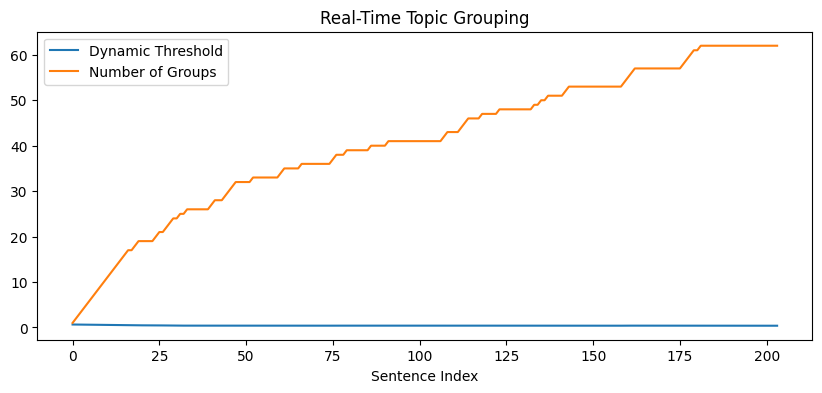


🧠 Final Groups:

Group 1:
  - Thank you so much, Neha, for what a wonderful introduction.
  - And Neha I think did a great job of describing the essence of what’s important here.

Group 2:
  - Everybody, please have a seat.

Group 3:
  - Nothing fills me with more hope than when I hear incredible young people like Neha and all the outstanding work that you’s doing on behalf of India’s youth and for representing this nation’s energy and its optimism and its idealism.
  - You’ve lifted countless millions from poverty and built one of the world’s largest middle classes. And nobody embodies this progress and this sense of possibility more than our young people.
  - We need our young people healthy for their futures.
  - As we keep working for a strong global agreement on climate change, it's young people like you who have to speak up, so we can protect this planet for your generation.
  - It's your generation and your children that are going to be impacted.
  - And that’s why young people

In [ ]:
import numpy as np
# Global memory to prevent regression
max_completion_so_far = 0

def calculate_novelty(batch_topics, topics, novelty_history, novelty_decay=0.05):
    if not batch_topics: return 0.0
    novelty = 0
    for topic_id in batch_topics:
        topic_data = topics.get(topic_id, {})
        if 'last_seen' in topic_data:
            batches_ago = len(novelty_history) - topic_data['last_seen']
            decay_factor = np.exp(-novelty_decay * batches_ago)
        else:
            decay_factor = 1.0
        count = topic_data.get('count', 1)
        novelty += decay_factor / (count ** 0.5)
    normalized = novelty / len(batch_topics)
    novelty_history.append(normalized)
    return normalized

def calculate_staleness(novelty_history, staleness_history):
    if len(novelty_history) < 3:
        staleness_history.append(0.0)
        return 0.0

    recent = novelty_history[-3:]
    x = np.arange(3)
    slope, _ = np.polyfit(x, recent, 1)

    # Low slope => staleness
    low_growth = max(0, 1 - slope * 5)

    if staleness_history:
        prev = staleness_history[-1]
        if slope < 0.02:
            staleness = min(1.0, prev + 0.05 * low_growth)
        else:
            decay = max(0.90, 1 - (len(staleness_history) * 0.015))  # progressive decay
            staleness = prev * decay
    else:
        staleness = low_growth

    staleness_history.append(staleness)
    return staleness

def predict_completion(current_batch_index, novelty_history, staleness_history, group_counts):
    global max_completion_so_far

    if len(novelty_history) < 3:
        completion = min(90, (current_batch_index + 1) * 100 / 10)  # assume 10 batches approx
    else:
        recent_novelty = np.mean(novelty_history[-3:])
        initial_novelty = np.mean(novelty_history[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0
        staleness = np.mean(staleness_history) if staleness_history else 0
        denominator = current_batch_index + 4

        # Predict completion
        completion = (
            0.2 * (current_batch_index + 1) / denominator +  # soft position ratio
            0.4 * novelty_decay +
            0.4 * staleness
        ) * 100

    # Prevent regression
    completion = max(completion, max_completion_so_far)
    completion = min(99, completion)
    max_completion_so_far = completion
    return completion

def linear_grouping_with_prediction(sentences, model, initial_threshold=0.65, decay_rate=0.01, min_threshold=0.4, window=3):
    embeddings, sentence_lengths = [], []
    groups, group_embeddings, group_weights = [], [], []
    threshold_history, group_counts = [], []

    topics = {}
    novelty_history, staleness_history = [], []

    for i, sentence in enumerate(sentences):
        new_embedding = model.encode(sentence, convert_to_tensor=True)
        length_weight = len(sentence.split())
        embeddings.append(new_embedding)
        sentence_lengths.append(length_weight)

        if i == 0:
            groups.append([0])
            group_embeddings.append(new_embedding)
            group_weights.append(length_weight)
            threshold_history.append(initial_threshold)
            group_counts.append(1)
            continue

        current_threshold = threshold_history[-1]
        best_sim, best_group = -1, None

        for group_idx, group_embed in enumerate(group_embeddings):
            sim = util.pytorch_cos_sim(new_embedding, group_embed).item()
            if sim > best_sim:
                best_sim, best_group = sim, group_idx

        if best_sim >= current_threshold:
            groups[best_group].append(i)
            group_indices = groups[best_group]
            weights = torch.tensor([sentence_lengths[idx] for idx in group_indices], device=new_embedding.device)
            stacked = torch.stack([embeddings[idx] for idx in group_indices])
            group_embeddings[best_group] = torch.sum(stacked * weights.view(-1, 1), dim=0) / torch.sum(weights)
            group_weights[best_group] += length_weight
            new_threshold = current_threshold * (1 - decay_rate / 5)
        else:
            groups.append([i])
            group_embeddings.append(new_embedding)
            group_weights.append(length_weight)
            new_threshold = max(min_threshold, current_threshold - decay_rate)

        threshold_history.append(new_threshold)
        group_counts.append(len(groups))

        # Predict after every window
        if (i + 1) % window == 0 or i == len(sentences) - 1:
            recent_ids = list(range(i - window + 1, i + 1))
            batch_group_ids = list(set(g for g, group in enumerate(groups) if any(idx in group for idx in recent_ids)))

            # Update topic memory
            for g in batch_group_ids:
                topics.setdefault(g, {'count': 0})
                topics[g]['count'] += 1
                topics[g]['last_seen'] = len(novelty_history)

            batch_index = len(novelty_history)
            novelty = calculate_novelty(batch_group_ids, topics, novelty_history)
            staleness = calculate_staleness(novelty_history, staleness_history)
            completion = predict_completion(batch_index, novelty_history, staleness_history, group_counts)

            print(f"\n📍 Batch {batch_index + 1} @ Sentence {i + 1}")
            print(f"Novelty: {novelty:.3f}, Staleness: {staleness:.3f}, Completion: {completion:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(threshold_history, label='Dynamic Threshold')
    plt.plot(group_counts, label='Number of Groups')
    plt.xlabel("Sentence Index")
    plt.title("Real-Time Topic Grouping")
    plt.legend()
    plt.show()

    print(f"\n🧠 Final Groups:")
    for idx, group in enumerate(groups):
        print(f"\nGroup {idx + 1}:")
        for sent_idx in group:
            print(f"  - {sentences[sent_idx]}")

linear_grouping_with_prediction(result, sentModel)

In [ ]:
def speech_project(text, model, initial_threshold=0.65, decay_rate=0.01, min_threshold=0.4, window=3):
    sentences = process_text(text)
    linear_grouping_with_prediction(sentences, model, initial_threshold)

In [ ]:
import re
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from collections import deque

# Text preprocessing functions
def clean_text_spacing(text):
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# Load sample text
text_test = open("sample.txt").read()
cleaned_text = clean_text_spacing(text_test)
sentences = split_into_sentences(cleaned_text)

# Initialize model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Topic tracking and novelty detection system
class TopicTracker:
    def __init__(self, novelty_decay=0.2, staleness_threshold=0.65):
        self.topics = {}  # topic_id: {'centroid', 'last_seen', 'count'}
        self.next_topic_id = 0
        self.novelty_decay = novelty_decay
        self.staleness_threshold = staleness_threshold
        self.novelty_history = deque(maxlen=10)
        self.staleness_history = deque(maxlen=10)

    def update_topics(self, batch_embeddings):
        """Cluster sentences and update topic registry"""
        # Convert to numpy for clustering
        embeddings_np = batch_embeddings.cpu().numpy() if isinstance(batch_embeddings, torch.Tensor) else batch_embeddings

        # Cluster using DBSCAN
        clustering = DBSCAN(eps=0.4, min_samples=1, metric='cosine').fit(embeddings_np)
        labels = clustering.labels_

        # Process clusters
        batch_topics = {}
        for label in set(labels):
            if label == -1:  # Handle noise as individual topics
                for i in np.where(labels == label)[0]:
                    topic_centroid = embeddings_np[i]
                    topic_id = self._match_or_create_topic(topic_centroid)
                    batch_topics[topic_id] = batch_topics.get(topic_id, []) + [i]
            else:
                indices = np.where(labels == label)[0]
                topic_centroid = np.mean(embeddings_np[indices], axis=0)
                topic_id = self._match_or_create_topic(topic_centroid)
                batch_topics[topic_id] = batch_topics.get(topic_id, []) + list(indices)

        return batch_topics

    def _match_or_create_topic(self, centroid):
        """Match to existing topic or create new one"""
        best_match = None
        best_sim = -1

        for topic_id, topic_data in self.topics.items():
            sim = 1 - distance.cosine(centroid, topic_data['centroid'])
            if sim > best_sim:
                best_sim = sim
                best_match = topic_id

        # Update existing topic or create new
        if best_sim > self.staleness_threshold:
            self.topics[best_match]['centroid'] = (
                self.topics[best_match]['centroid'] + centroid
            ) / 2
            self.topics[best_match]['count'] += 1
            self.topics[best_match]['last_seen'] = len(self.novelty_history)
            return best_match
        else:
            self.topics[self.next_topic_id] = {
                'centroid': centroid,
                'last_seen': len(self.novelty_history),
                'count': 1
            }
            self.next_topic_id += 1
            return self.next_topic_id - 1

    def calculate_novelty(self, batch_topics):
        """Calculate novelty score for current batch"""
        if not batch_topics:
            return 0.0

        novelty = 0
        for topic_id in batch_topics:
            topic_data = self.topics[topic_id]
            # Calculate decay based on how many batches since last seen
            if 'last_seen' in topic_data:
                batches_ago = len(self.novelty_history) - topic_data['last_seen']
                decay_factor = np.exp(-self.novelty_decay * batches_ago)
            else:
                decay_factor = 1.0  # New topic

            # Higher novelty for topics seen fewer times
            novelty += decay_factor / (topic_data['count'] ** 0.5)

        # Normalize by number of topics
        normalized_novelty = novelty / len(batch_topics)
        self.novelty_history.append(normalized_novelty)
        return normalized_novelty

    def calculate_staleness(self):
        """Calculate staleness based on novelty trend"""
        if len(self.novelty_history) < 3:
            return 0.0

        # Calculate trend of last 3 novelty scores
        recent_novelty = list(self.novelty_history)[-3:]
        x = np.arange(3)
        slope, _ = np.polyfit(x, recent_novelty, 1)

        # Staleness increases when novelty decreases
        staleness = max(0, -slope * 5)  # Scale slope to [0,1] range
        self.staleness_history.append(staleness)
        return min(1.0, staleness)


    def predict_completion(self, current_batch_index, total_batches, sentences):
        """Predict completion percentage"""
        if len(self.novelty_history) < 3:
            # Not enough data, use position-based estimate
            position_ratio = current_batch_index / total_batches if total_batches > 0 else 0
            return min(90, position_ratio * 100)

        # Position-based completion
        position_ratio = current_batch_index / total_batches

        # Novelty decay factor
        recent_novelty = np.mean(list(self.novelty_history)[-3:])
        initial_novelty = np.mean(list(self.novelty_history)[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0

        # Staleness factor
        staleness = np.mean(self.staleness_history) if self.staleness_history else 0

        # Combine factors with weights
        completion = (
            0.2 * position_ratio +
            0.3 * novelty_decay +
            0.5 * staleness
        )

        return min(99, completion * 100)

# Process text in batches
BATCH_SIZE = 5
tracker = TopicTracker()

print("Processing speech and predicting completion:\n")
print(f"{'Batch':<6} | {'Topics':<6} | {'Novelty':<7} | {'Staleness':<9} | {'Completion':<10} | Status")
print("-" * 70)

for batch_idx in range(0, len(sentences), BATCH_SIZE):
    batch_sentences = sentences[batch_idx:batch_idx+BATCH_SIZE]
    batch_embeddings = model.encode(batch_sentences, convert_to_tensor=True)

    # Update topics and calculate novelty
    batch_topics = tracker.update_topics(batch_embeddings)
    novelty = tracker.calculate_novelty(batch_topics)
    staleness = tracker.calculate_staleness()

    # Predict completion percentage
    completion = tracker.predict_completion(
        batch_idx // BATCH_SIZE,
        len(sentences) // BATCH_SIZE,
        batch_sentences
    )

    # Visual progress bar
    progress_bar = "[" + "=" * int(completion / 5) + " " * (20 - int(completion / 5)) + "]"

    print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")

    # Early exit if completion is high
    if completion > 95:
        print("\n[!] Speech completion predicted - ending analysis")
        break

# Final topic analysis
print("\nTopic Summary:")
for topic_id, topic_data in tracker.topics.items():
    print(f"Topic {topic_id}: Seen {topic_data['count']} times")

Processing speech and predicting completion:

Batch  | Topics | Novelty | Staleness | Completion | Status
----------------------------------------------------------------------
1      | 5      | 1.0000  | 0.0000    |    0.0%    | [                    ]
2      | 5      | 1.0000  | 0.0000    |    2.0%    | [                    ]
3      | 5      | 1.0000  | 0.0000    |    0.8%    | [                    ]
4      | 5      | 0.9414  | 0.1464    |    5.4%    | [=                   ]
5      | 2      | 0.8536  | 0.3661    |   12.2%    | [==                  ]
6      | 5      | 1.0000  | 0.0000    |   10.4%    | [==                  ]
7      | 5      | 1.0000  | 0.0000    |    8.9%    | [=                   ]
8      | 4      | 1.0000  | 0.0000    |    7.0%    | [=                   ]
9      | 3      | 0.9024  | 0.2441    |    9.5%    | [=                   ]
10     | 5      | 1.0000  | 0.0000    |    9.2%    | [=                   ]
11     | 5      | 1.0000  | 0.0000    |    8.5%    | [=        